# Работа с данными

датасеты - https://neurohive.io/ru/datasety/datasety-dlya-generacii-i-analiza-muzyki/

maestro - https://magenta.tensorflow.org/datasets/maestro#dataset

работа с MIDI - https://www.tensorflow.org/tutorials/audio/music_generation

In [1]:
#%%capture
#! pip install --upgrade pyfluidsynth
#! pip install pretty_midi
#! pip install pyfluidsynth

Задача проекта - написать модель, которая будет генерировать музыку. Наша модель обучается на midi-файлах датасета Maestro. На выходе наша модель также будет выдавать сгенерированный midi-файл.

Для начала поработаем с MIDI-файлами для пианино из датасета MAESTRO. Основываясь на последовательности нот, модель будет обучена предсказывать следующую ноту в этой последовательности. Используя модель многократно, мы сможете создавать удлиненные последовательности нот.

In [2]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import pathlib
import pretty_midi

from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
_SAMPLING_RATE = 16000


Скачиваем данные в папку data_dir и распаковываем их.

In [3]:
from data import load_to_folder

data_dir = pathlib.Path('data/maestro-v2.0.0')

filenames = load_to_folder(data_dir)

Количество скаченных midi-файлов: 1282


Возьмем рандомный MIDI файл и посмотрим на него.

In [4]:
from midi_and_notes import display_audio
sample_file = filenames[1]
print(sample_file)

pm = pretty_midi.PrettyMIDI(sample_file)
display_audio(pm)

data/maestro-v2.0.0/2013/ORIG-MIDI_03_7_6_13_Group__MID--AUDIO_09_R1_2013_wav--2.midi


fluidsynth: error: Unknown integer parameter 'synth.sample-rate'


Также мы можем менять количество инструментов в мелодии и сами инструменты, так как midi-уникальный файл, в котором можем легко менять музыкальные инструменты.

In [5]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 1
Instrument name: Acoustic Grand Piano


Каждая нота описывается характеристиками:

Базовые:
- pitch - каждому числу соответствует определённая нота с определённой высотой звука.
- start - время начала ноты
- end - время окончания ноты

Косвенные (выводятся из базовых):
- note_name - обозначение ноты
- step - время, прошедшее с предыдущей ноты или начала дорожки
- duration - продолжительность звучания ноты = end - start

In [6]:
from midi_and_notes import midi_to_notes

raw_notes = midi_to_notes(sample_file)
raw_notes.head()

pitch     start       end      step  duration
0     63  1.001302  1.079427  0.000000  0.078125
1     75  1.006510  1.074219  0.005208  0.067708
2     75  1.305990  1.350260  0.299479  0.044271
3     63  1.305990  1.352865  0.000000  0.046875
4     75  1.630208  1.671875  0.324219  0.041667

In [7]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['D#4', 'D#5', 'D#5', 'D#4', 'D#5', 'D#4', 'D#7', 'D#6', 'D#7',
       'D#6'], dtype='<U3')

Также можем визуализировать мелодию или ее кусок, в дальнейшем это пригодится для анализа нормальности сгенерированного аудио

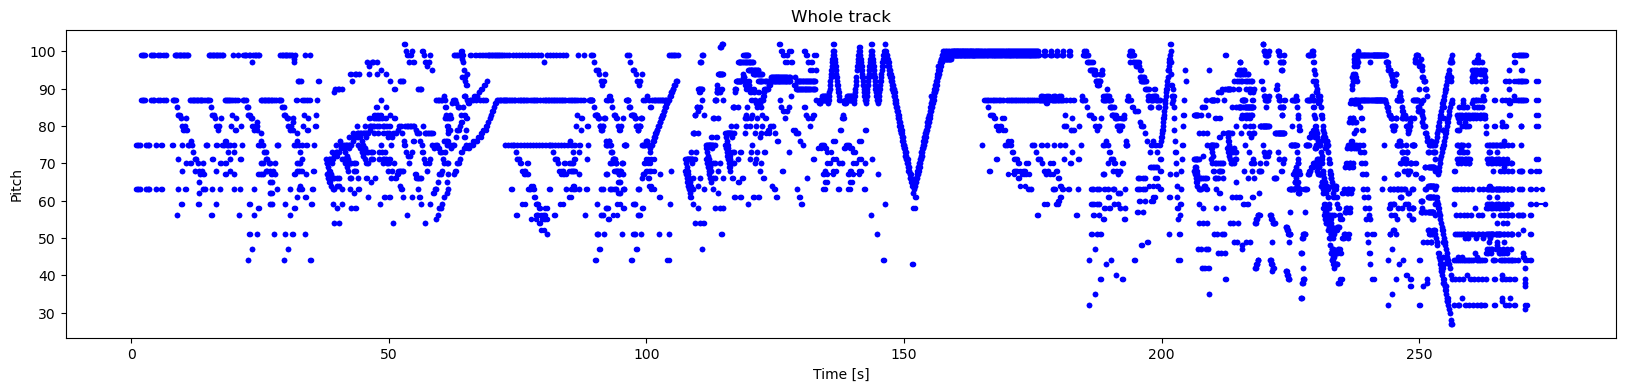

In [8]:
from data import plot_piano_roll
plot_piano_roll(raw_notes)

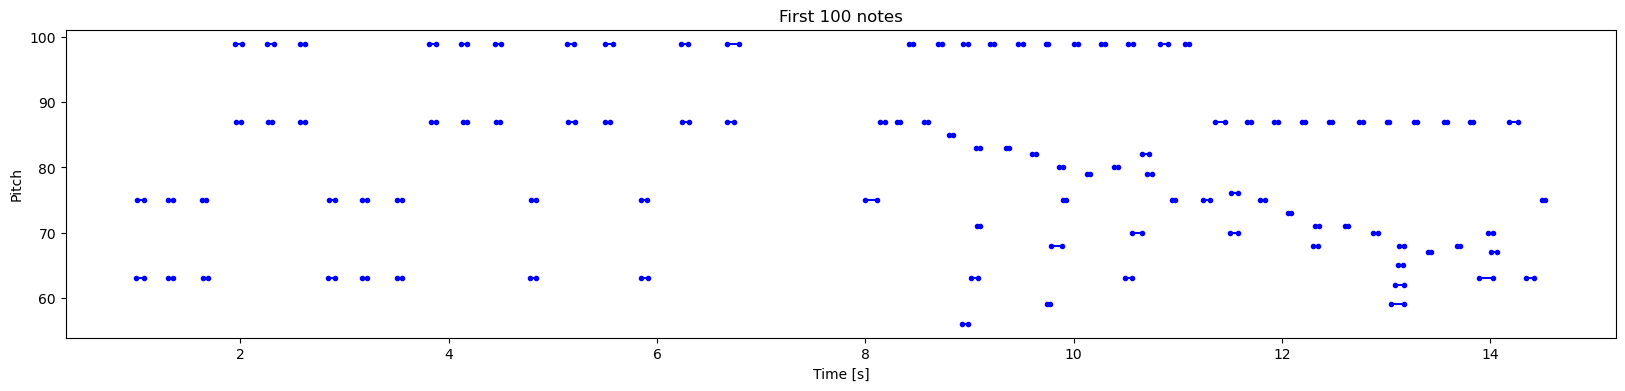

In [9]:
plot_piano_roll(raw_notes, count=100)

Теперь создадим датасет на основании всех наших midi-файлов из Maestro

In [10]:
from data import get_array_data
train_data = get_array_data(filenames)
print(f'всего мелодий в датасете = {len(train_data)}')

всего мелодий в датасете = 1282


In [11]:
train_data[1001]

pitch       start         end      step  duration
0       62    1.009115    1.229167  0.000000  0.220052
1       62    1.454427    1.648438  0.445312  0.194010
2       62    1.929688    2.132812  0.475260  0.203125
3       55    2.380208    3.425781  0.450521  1.045573
4       59    3.317708    4.819010  0.937500  1.501302
..     ...         ...         ...       ...       ...
867     62  167.026042  171.802083  0.832031  4.776042
868     38  167.042969  171.830729  0.016927  4.787760
869     57  167.046875  171.773438  0.003906  4.726562
870     54  167.048177  171.776042  0.001302  4.727865
871     50  167.055990  171.776042  0.007812  4.720052

[872 rows x 5 columns]

In [12]:
train_data_normal = []
for i in range(len(train_data)):
    train_data_normal.append(train_data[i][['pitch', 'step', 'duration']])

In [13]:
train_data_normal[1001]

pitch      step  duration
0       62  0.000000  0.220052
1       62  0.445312  0.194010
2       62  0.475260  0.203125
3       55  0.450521  1.045573
4       59  0.937500  1.501302
..     ...       ...       ...
867     62  0.832031  4.776042
868     38  0.016927  4.787760
869     57  0.003906  4.726562
870     54  0.001302  4.727865
871     50  0.007812  4.720052

[872 rows x 3 columns]

In [14]:
from data import collate_fn_pad, SongsDataset

import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

dataset = SongsDataset(train_data_normal)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn_pad)

Давайте перейдем непосредственно к построению VAE-GANа. Напомним, что VAE-GAN состоит из двух сетей генератора(VAE), задача которого – научиться генерировать аудио, похожие на обучающую выборку, из случайного шума, и дискриминатора, который учится распознавать, настоящее это аудио или сгенерированное генератором.

Обучение VAE-GAN состоит из нескольких ключевых этапов:

Энкодер (VAE часть): На первом этапе, энкодер принимает входные данные и отображает их в латентное пространство. Это пространство представляет сжатое представление входных данных. Энкодер обычно состоит из последовательности слоев нейронной сети.

Декодер (VAE часть): Затем, декодер берет сжатое представление из латентного пространства и пытается воссоздать исходные данные. Обучение VAE включает в себя минимизацию различий между входными данными и их воссозданными версиями, а также регуляризацию латентного пространства (через KL-дивергенцию).

Дискриминатор (GAN часть): Параллельно, дискриминатор, который также является нейронной сетью, обучается различать настоящие входные данные от данных, сгенерированных декодером. Дискриминатор пытается отличить "реальные" данные от "поддельных", а декодер (или генератор) старается обмануть дискриминатор, генерируя всё более реалистичные данные.

В процессе обучения VAE и GAN части модели обучаются одновременно, что позволяет создать эффективную генеративную модель, способную генерировать качественные и реалистичные данные.

Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные аудио и присваиваем им метку 1
  * генерируем аудио генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем аудио генератором и присваиваем им метку 1
  * предсказываем дискриминаторором, реальное это аудио или нет

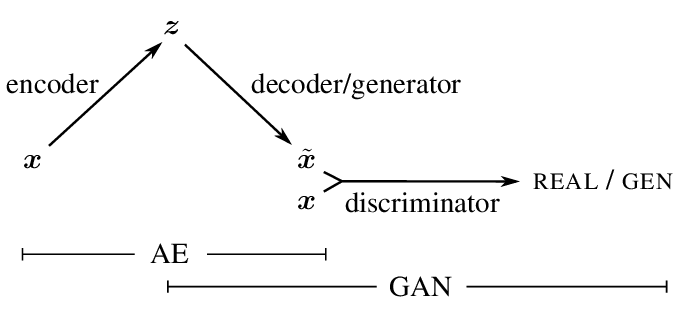

In [15]:
from IPython.display import Image
Image(filename='images/схема.png')

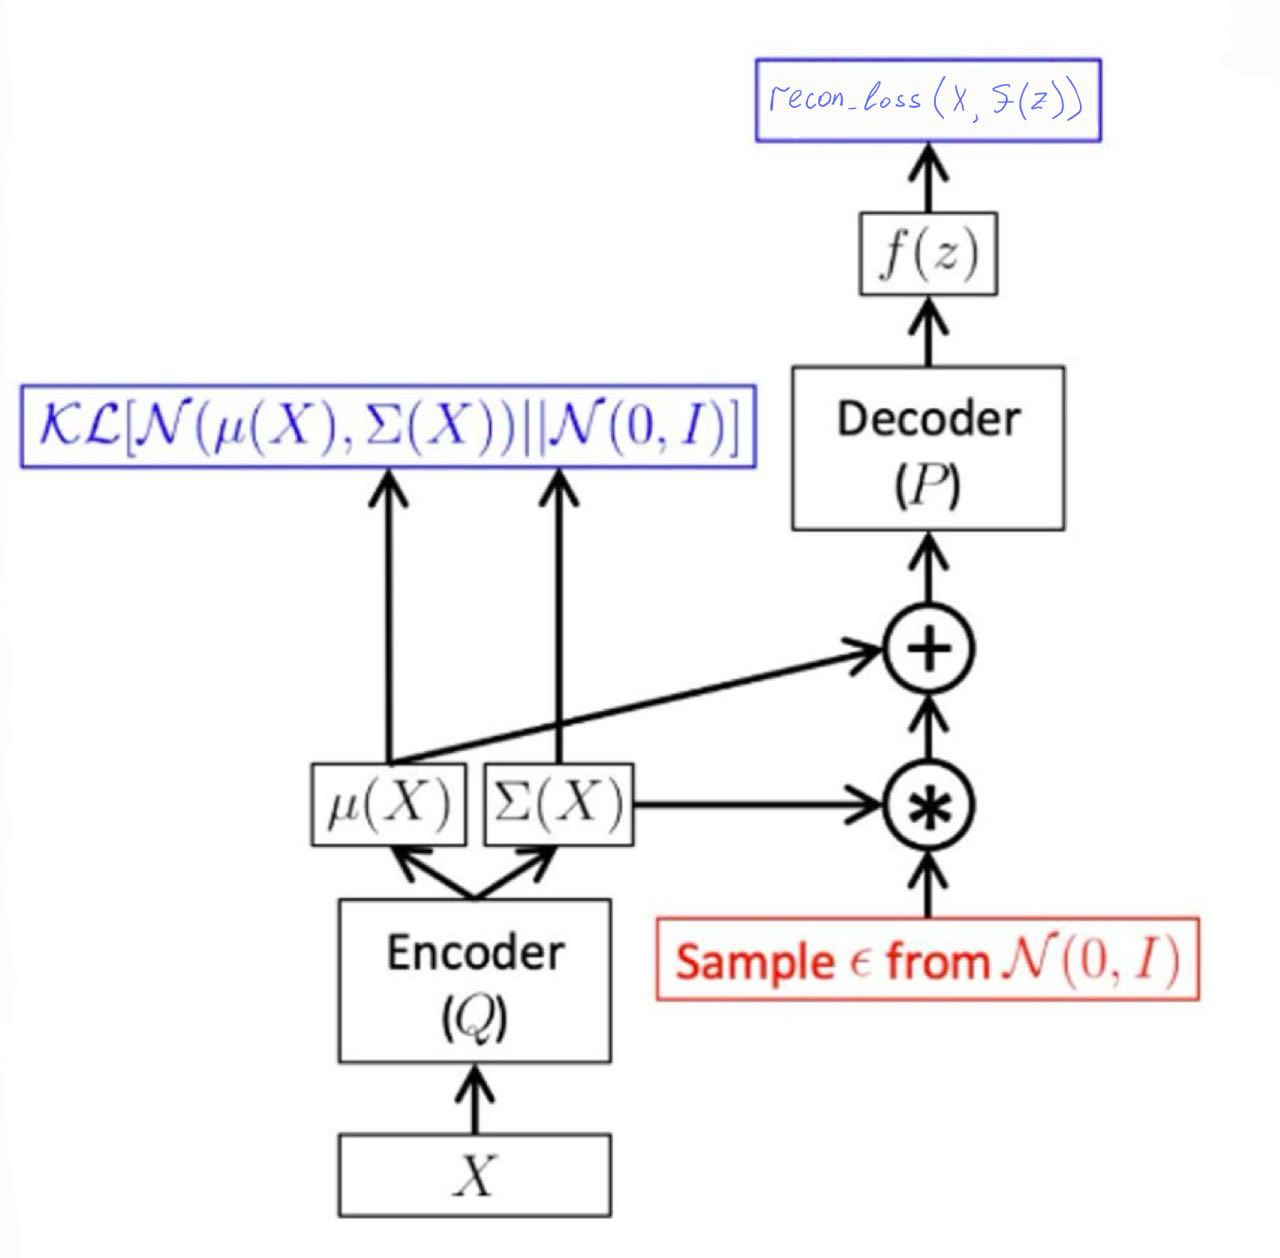

In [30]:
from IPython.display import Image
Image(filename='images/схемаVAE.jpeg')

Про эффективность VAE-GAN:

в картинках - https://wandb.ai/shambhavicodes/vae-gan/reports/An-Introduction-to-VAE-GANs--VmlldzoxMTcxMjM5

https://github.com/rishabhd786/VAE-GAN-PYTORCH

в аудио -    https://habr.com/ru/companies/ruvds/articles/715258/

Вообще латентное пространство устроено очень интресно, а именно наши песни отображаются в латентное пространство с помощью encoder-а. И соответственно в этом пространстве каждая песня представляет из себя какую-то точку из этого пространства. Допустим мы отразили 2 песни в латентное простанство и теперь имеем 2 точки в нем - a(первая песня) и b(вторая песня). Соеденив две эти точки, мы получим вектор вдоль которого можно двигаться, тем самым, получая новую песню, как комбинацию a и b.

Ниже мы видим пример, как одно лицо из латентного пространства переходит в другое лицо. А по середине мы видим комбинацию этих двух лиц, которое генерирует наш VAE. Такой пример я нашла в материалах МФТИ - https://colab.research.google.com/drive/1TxwbGEY5FzoT-F6Z2su_p0RlgqanB-pY

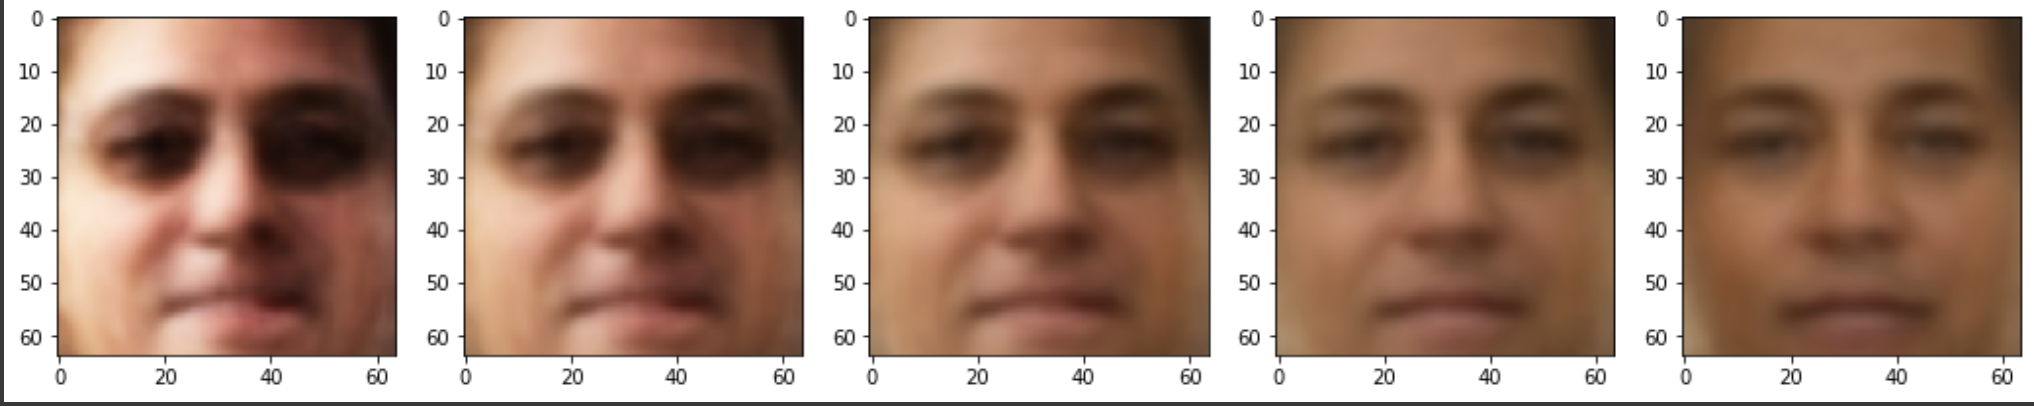

In [17]:
from IPython.display import Image
Image(filename='images/latent.png')

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from model import VAE 

vae = VAE()
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# Обучение модели
vae.train_model(dataloader, optimizer, epochs=100)

Эпоха 1, Средние потери: 81315.45065083854
Эпоха 2, Средние потери: 83702.97750097504
Эпоха 3, Средние потери: 83561.78811183697
Эпоха 4, Средние потери: 82465.74442399571
Эпоха 5, Средние потери: 81997.46733619345
Эпоха 6, Средние потери: 81729.05557722309
Эпоха 7, Средние потери: 80652.79756971529
Эпоха 8, Средние потери: 79648.60808307333
Эпоха 9, Средние потери: 79580.78390088728
Эпоха 10, Средние потери: 78901.77248683697
Эпоха 11, Средние потери: 78159.17102184087
Эпоха 12, Средние потери: 78087.73500877534
Эпоха 13, Средние потери: 77538.2805674727
Эпоха 14, Средние потери: 77079.75092628704
Эпоха 15, Средние потери: 76941.8588874805
Эпоха 16, Средние потери: 76247.88923556943
Эпоха 17, Средние потери: 75960.09240932137
Эпоха 18, Средние потери: 75500.92816400155
Эпоха 19, Средние потери: 75265.96676335804
Эпоха 20, Средние потери: 74479.65606718019
Эпоха 21, Средние потери: 74293.04822786662
Эпоха 22, Средние потери: 74361.98130362715
Эпоха 23, Средние потери: 73676.80295680577

In [19]:
# Генерация новой мелодии
sample = vae.generate_song()
sample_np = sample.numpy()

df_generated = pd.DataFrame(sample_np[0], columns=['pitch', 'step', 'duration'])
df_generated

pitch      step  duration
0    57.0  0.006143  0.919530
1    57.0  0.203799  0.755724
2    57.0  0.282384  0.626679
3    71.0  0.221506  0.486657
4    62.0  0.320797  0.429158
..    ...       ...       ...
95   60.0  0.156165  0.274287
96   66.0  0.163574  0.275081
97   53.0  0.158112  0.283953
98   66.0  0.135493  0.269173
99   63.0  0.147854  0.266654

[100 rows x 3 columns]

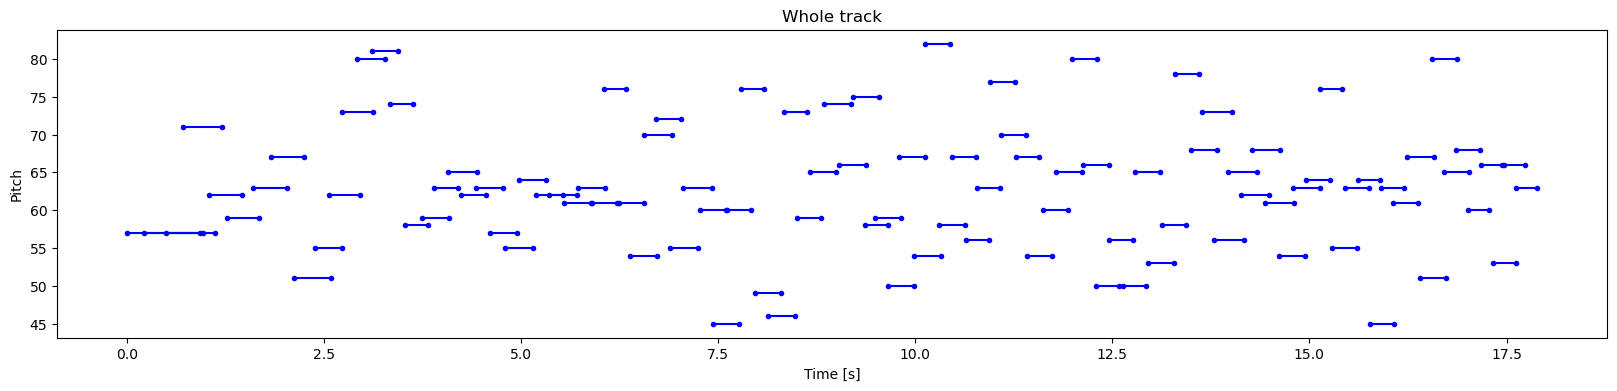

In [20]:
from midi_and_notes import recover_end_and_start

midi_recover = recover_end_and_start(df_generated)
plot_piano_roll(midi_recover)

In [21]:
from midi_and_notes import display_audio, notes_to_midi

out_file = 'output.mid'
out_pm = notes_to_midi(midi_recover, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

fluidsynth: error: Unknown integer parameter 'synth.sample-rate'


Теперь соберем VAEGAN

Эпоха 1/100,	 Loss D: 0.7020576247354833,	 Loss G: 2571624.3997713416
Эпоха 2/100,	 Loss D: 0.6960634516506661,	 Loss G: 2569444.6673018294
Эпоха 3/100,	 Loss D: 0.6920657797557551,	 Loss G: 2601689.2930640243
Эпоха 4/100,	 Loss D: 0.6894133483491293,	 Loss G: 2636931.15472561
Эпоха 5/100,	 Loss D: 0.6861953124767397,	 Loss G: 2648795.9058689023
Эпоха 6/100,	 Loss D: 0.6849861842830006,	 Loss G: 2685292.3102134145
Эпоха 7/100,	 Loss D: 0.6821795454839381,	 Loss G: 2710615.765625
Эпоха 8/100,	 Loss D: 0.6795958062497581,	 Loss G: 2721506.175304878
Эпоха 9/100,	 Loss D: 0.67654147526113,	 Loss G: 2742125.3410823173
Эпоха 10/100,	 Loss D: 0.6749339089161013,	 Loss G: 2739731.8182164636
Эпоха 11/100,	 Loss D: 0.6727189232663411,	 Loss G: 2754696.0152439023
Эпоха 12/100,	 Loss D: 0.6692573878823257,	 Loss G: 2757158.2160823173
Эпоха 13/100,	 Loss D: 0.6684680014121823,	 Loss G: 2745179.6897865855
Эпоха 14/100,	 Loss D: 0.6638355749409374,	 Loss G: 2749290.658155488
Эпоха 15/100,	 Loss D: 0.

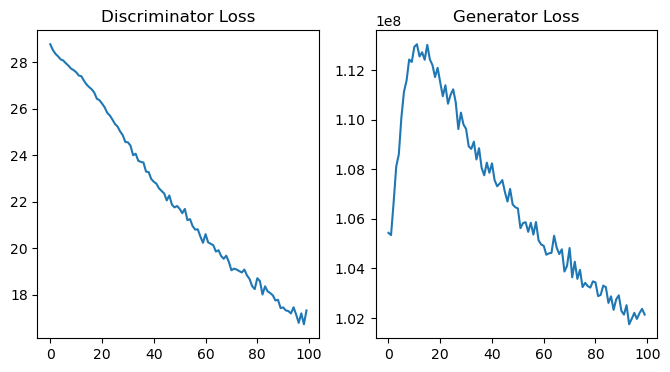

In [22]:
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam
from model import VAEGAN

vaegan = VAEGAN()

optimizer_G = Adam(vaegan.vae.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = Adam(vaegan.discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Количество эпох для обучения
epochs = 100

history_loss_d, history_loss_g = [], []
# Процесс обучения
for epoch in range(epochs):
    epoch_loss_D, epoch_loss_G = 0, 0
    for batch_idx, data in enumerate(dataloader):

        if torch.cuda.is_available():
            data = data.cuda()
        
        d_loss, g_loss = vaegan.train_step(data, optimizer_G, optimizer_D)
        
        epoch_loss_D += d_loss
        epoch_loss_G += g_loss
    history_loss_d.append(epoch_loss_D)
    history_loss_g.append(epoch_loss_G)
    
    print(f'Эпоха {epoch+1}/{epochs},\t Loss D: {epoch_loss_D / len(dataloader)},\t Loss G: {epoch_loss_G / len(dataloader)}')

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].plot(range(epochs), history_loss_d)
axs[0].set_title('Discriminator Loss')

axs[1].plot(range(epochs), history_loss_g)
axs[1].set_title('Generator Loss')



num_songs = 5
generated_songs = vaegan.generate_song(num_songs)

Text(0.5, 1.0, 'Generator Loss')

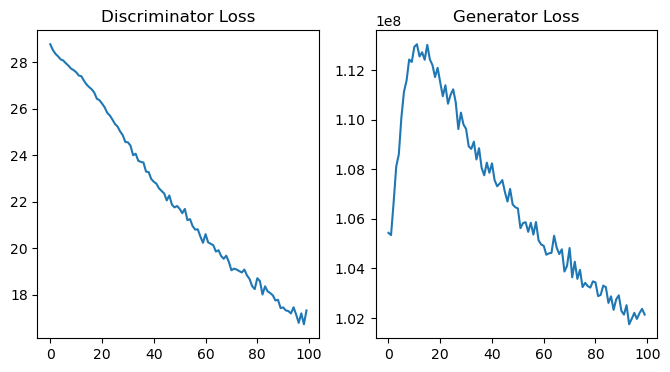

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4)) 

axs[0].plot(range(epochs), history_loss_d)
axs[0].set_title('Discriminator Loss')

axs[1].plot(range(epochs), history_loss_g)
axs[1].set_title('Generator Loss')

In [24]:
from midi_and_notes import recover_end_and_start

sample_np = generated_songs.numpy()

df_generated = pd.DataFrame(sample_np[0], columns=['pitch', 'step', 'duration'])
df_generated

pitch      step  duration
0    48.0  0.022902  0.907613
1    61.0  0.180625  0.738387
2    70.0  0.257796  0.684385
3    70.0  0.230770  0.523324
4    69.0  0.339356  0.466850
..    ...       ...       ...
95   56.0  0.172253  0.285725
96   46.0  0.186154  0.287051
97   60.0  0.123888  0.304172
98   69.0  0.153776  0.301298
99   78.0  0.128091  0.322913

[100 rows x 3 columns]

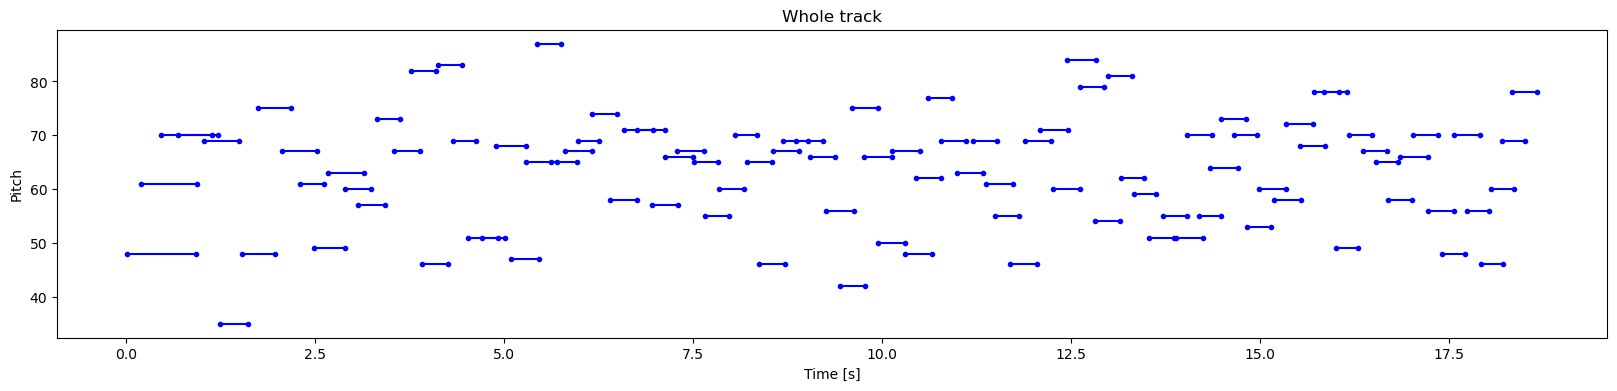

In [25]:
from midi_and_notes import recover_end_and_start

midi_recover = recover_end_and_start(df_generated)
plot_piano_roll(midi_recover)

In [26]:
from midi_and_notes import display_audio, notes_to_midi

out_file = 'output.mid'
out_pm = notes_to_midi(midi_recover, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

fluidsynth: error: Unknown integer parameter 'synth.sample-rate'


Если закодировать и декодировать мелодию из трейн, то получим:

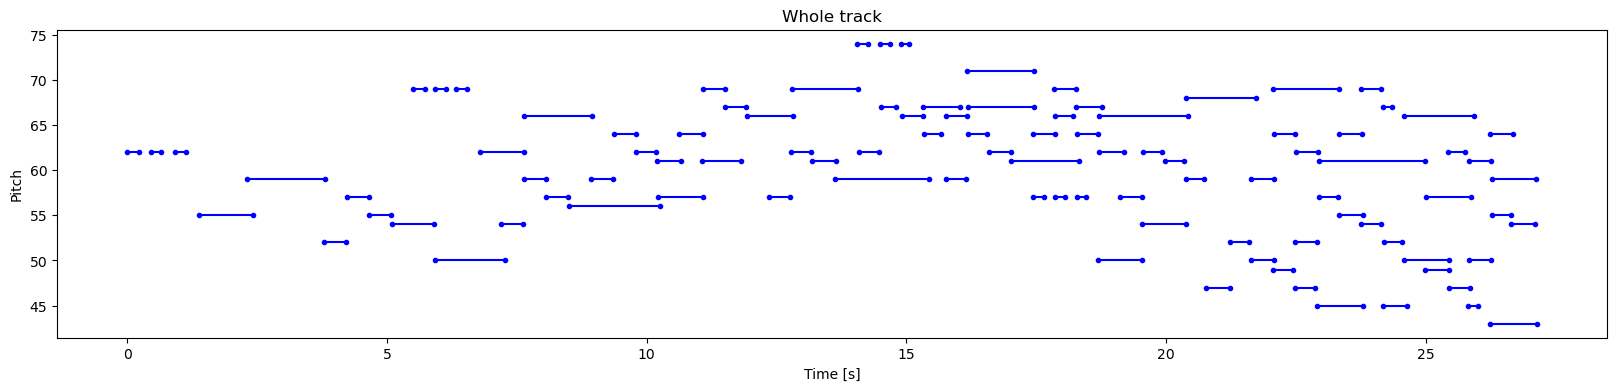

In [31]:
real = pd.DataFrame(train_data_normal[1001][0:100], columns=['pitch', 'step', 'duration'])
real = recover_end_and_start(real)
plot_piano_roll(real)

In [32]:
from midi_and_notes import display_audio, notes_to_midi

out_file = 'real.mid'
out_pm = notes_to_midi(real, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

fluidsynth: error: Unknown integer parameter 'synth.sample-rate'


In [33]:
data_tensor = torch.tensor(train_data_normal[1001][0:100].values, dtype=torch.float32).unsqueeze(0)
data_tensor.shape
# Передача данных в модель
output, _, _ = vaegan.vae.forward(data_tensor)

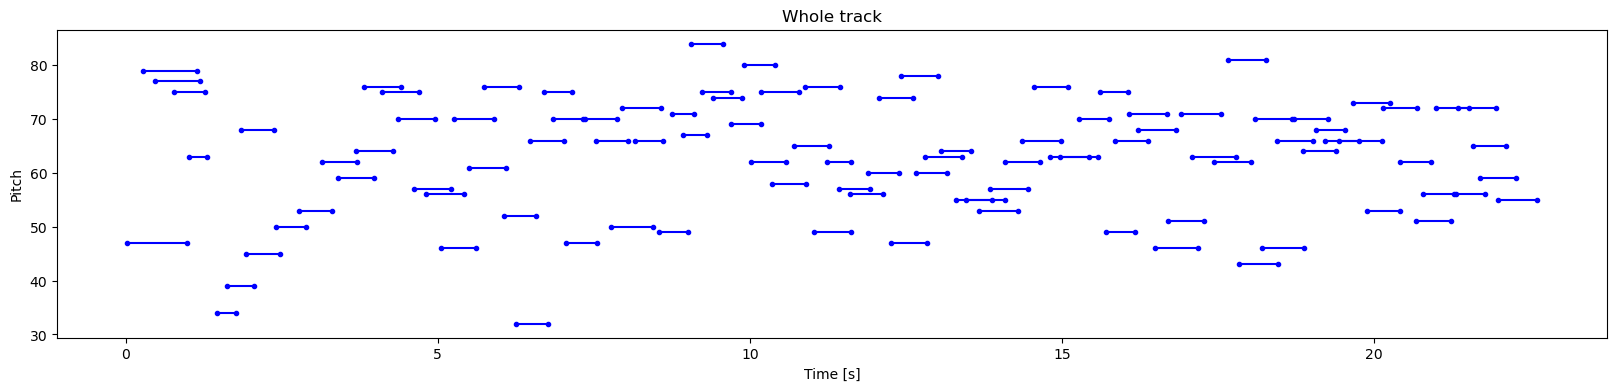

In [34]:
from midi_and_notes import recover_end_and_start

df_generated = pd.DataFrame(output.detach().numpy()[0], columns=['pitch', 'step', 'duration'])
df_generated

midi_recover = recover_end_and_start(df_generated)
plot_piano_roll(midi_recover)

In [35]:
from midi_and_notes import display_audio, notes_to_midi

out_file = 'recover.mid'
out_pm = notes_to_midi(midi_recover, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

fluidsynth: error: Unknown integer parameter 'synth.sample-rate'


Потери дискриминатора в начале обучения были низкими, что может указывать на то, что дискриминатору в начале было легко различать реальные данные от сгенерированных. Однако со временем потери дискриминатора увеличились и стабилизировались, что может свидетельствовать о том, что дискриминатору стало сложно отличать реальные данные от сгенерированных.

Генератор показывает очень низкую и стабильную потерю после начального пика, что может быть признаком того, что он не получает достаточный градиент для обучения или что дискриминатор стал слишком хорош для текущего состояния генератора. Это может указывать на то, что генератор либо слишком хорошо подстраивается под текущее состояние дискриминатора с самого начала, либо не обучается должным образом, чтобы улучшать свои способности генерации.

Значительная разница между потерями дискриминатора и генератора может быть признаком того, что одна из сетей доминирует над другой. В идеале потери должны сближаться, что указывало бы на то, что обе сети постепенно учатся и улучшают свои способности, и достигается точка равновесия.

Модель генерирует данные, но не учитывает их особенность. Как можно улучшить это?

Улучшения:

    1 pitch сделать категориальным признаком. Тогда столбца pitch следует использовать кросс-энтропийную функцию потерь, так как это задача классификации. Для остальных числовых признаков подходит среднеквадратичная ошибка.
    
    2 убрать end, чтобы не было лин зависимости при обучении
    
    3 рассмотреть WaveNet в качестве декодора, так делает NSynth - https://magenta.tensorflow.org/nsynt На самом деле это сложный декодер. Основная особенность WaveNet – использование дилатационных сверток, которые позволяют сети эффективно работать с временными последовательностями. В WaveNet использует последовательность сверточных слоев с увеличивающимся dilation_rate, что позволяет модели обрабатывать информацию на различных временных масштабах, улавливая как короткие, так и длинные зависимости в аудио сигнале.
   
    4 Временные ряды можно обрабатывать через сверточные слои (для улавливания временных зависимостей), а категориальные данные - через полносвязные слои.
    
    5 Input из tensorflow.keras - работает именно с временными даннами, надо его использовать для start (/ end)